In [1]:
!pip3 install torchvision
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

In [3]:
transform_train = transforms.Compose([transforms.Resize((32,32)),
                               transforms.RandomHorizontalFlip(),
                               transforms.RandomRotation(10),
                               transforms.RandomAffine(0, shear = 10 , scale=(0.8,1.2)),
                               transforms.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                              ])


transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                              ])
training_datasets = datasets.CIFAR10(root = './data', train = True,download = True, transform = transform_train)
validation_datasets = datasets.CIFAR10(root = './data', train = False,download = True, transform = transform)
train_loader = torch.utils.data.DataLoader(dataset=training_datasets,batch_size = 100,shuffle = True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_datasets,batch_size = 100,shuffle = False)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
training_datasets

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               RandomAffine(degrees=(0, 0), scale=(0.8, 1.2), shear=(-10, 10))
               ColorJitter(brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.8, 1.2], hue=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [8]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1,2,0)
  print(image.shape)
  image = image * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5)) 
  image = image.clip(0,1)
  return image

In [9]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


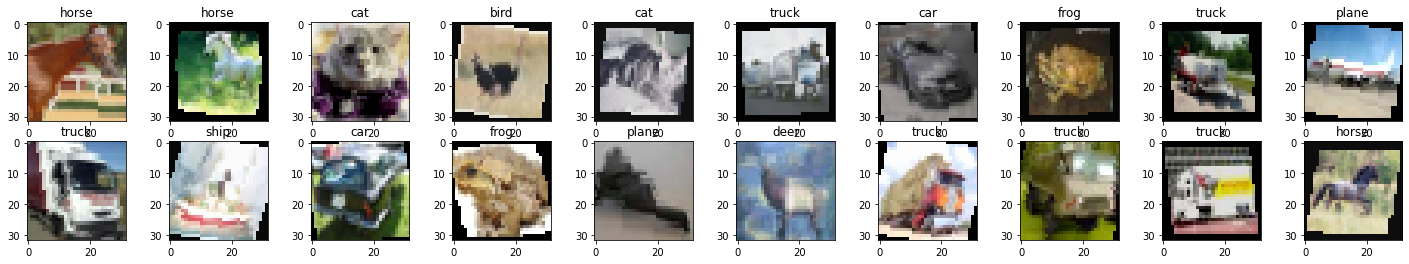

In [10]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25,4))

for i in np.arange(20):
  ax = fig.add_subplot(2,10,i+1)
  plt.imshow(im_convert(images[i]))
  ax.set_title(classes[labels[i].item()])

In [11]:
from torch import nn

In [12]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,16,3,1, padding =1)
    self.conv2 = nn.Conv2d(16,32,3,1,padding =1)
    self.conv3 = nn.Conv2d(32,64,3,1, padding =1)
    self.fc1 = nn.Linear(64*4*4,500)
    self.dropout = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500,10)

  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x,2,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x,2,2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x,2,2)
    x = x.view(-1,64*4*4)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x 

In [13]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

In [15]:
epochs = 12
running_loss_history = []
running_correct_history = []
validation_running_loss_history = []
validation_running_correct_history = []
for i in range(epochs):
  running_loss = 0.0
  running_correct = 0.0
  validation_running_loss = 0.0
  validation_running_correct = 0.0
  for inputs, labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    outputs = model.forward(inputs)
    loss = criterion(outputs,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    _,pred = torch.max(outputs,1)
    running_correct += torch.sum(pred == labels.data)
  else:
    with torch.no_grad():
      for val_inputs,val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model.forward(val_inputs)
        val_loss = criterion(val_outputs,val_labels)
        validation_running_loss += val_loss.item()
        _,val_pred = torch.max(val_outputs,1)
        validation_running_correct += torch.sum(val_pred == val_labels.data)

    epoch_loss = running_loss/len(train_loader)
    epoch_accuracy = running_correct.float()/len(train_loader)
    running_loss_history.append(epoch_loss)
    running_correct_history.append(epoch_accuracy)

    val_epoch_loss = validation_running_loss/len(validation_loader)
    val_epoch_accuracy = validation_running_correct.float()/len(validation_loader)
    validation_running_loss_history.append(val_epoch_loss)
    validation_running_correct_history.append(val_epoch_accuracy)

    print('epoch is {}'.format(i))
    print('training_loss {:.4f}, training_accuracy {:.4f}'.format(epoch_loss, epoch_accuracy.item()))
    print('val_training_loss {:.4f}, val_training_accuracy {:.4f}'.format(val_epoch_loss, val_epoch_accuracy.item())) 

epoch is 0
training_loss 1.6878, training_accuracy 38.1000
val_training_loss 1.4140, val_training_accuracy 48.6000
epoch is 1
training_loss 1.3968, training_accuracy 49.5180
val_training_loss 1.2648, val_training_accuracy 55.7400
epoch is 2
training_loss 1.2757, training_accuracy 54.4660
val_training_loss 1.1368, val_training_accuracy 59.6500
epoch is 3
training_loss 1.1820, training_accuracy 58.0120
val_training_loss 1.0706, val_training_accuracy 61.7500
epoch is 4
training_loss 1.1158, training_accuracy 60.3840
val_training_loss 1.0042, val_training_accuracy 64.4700
epoch is 5
training_loss 1.0613, training_accuracy 62.3800
val_training_loss 0.9641, val_training_accuracy 65.9100
epoch is 6
training_loss 1.0269, training_accuracy 63.7720
val_training_loss 0.9308, val_training_accuracy 67.5800
epoch is 7
training_loss 0.9886, training_accuracy 65.3920
val_training_loss 0.8986, val_training_accuracy 68.4500
epoch is 8
training_loss 0.9619, training_accuracy 66.3960
val_training_loss 0.8

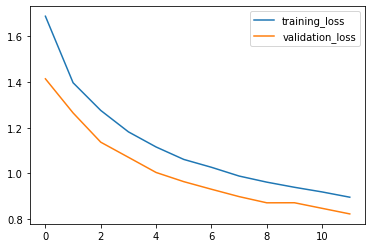

In [16]:
plt.plot(running_loss_history,label = 'training_loss')
plt.plot(validation_running_loss_history,label = 'validation_loss')
plt.legend()

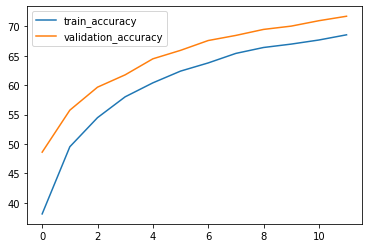

In [17]:
plt.plot(running_correct_history, label = 'train_accuracy')
plt.plot(validation_running_correct_history, label = 'validation_accuracy')
plt.legend()

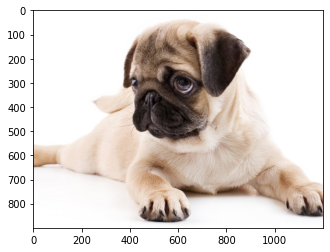

In [18]:
import requests
from PIL import Image
url = "https://i.guim.co.uk/img/media/fe1e34da640c5c56ed16f76ce6f994fa9343d09d/0_174_3408_2046/master/3408.jpg?width=1200&height=900&quality=85&auto=format&fit=crop&s=0d3f33fb6aa6e0154b7713a00454c83d"
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

(32, 32, 3)


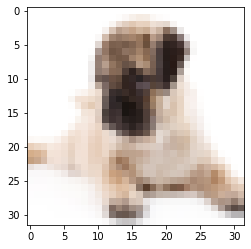

In [19]:
import PIL.ImageOps
from PIL import ImageMath

img = transform(img)
plt.imshow(im_convert(img))

In [ ]:
img.shape

torch.Size([3, 32, 32])

In [20]:
img = img.to(device).unsqueeze(0)

output = model.forward(img)
_,pred = torch.max(output,1)
print(classes[pred.item()])

bird


(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


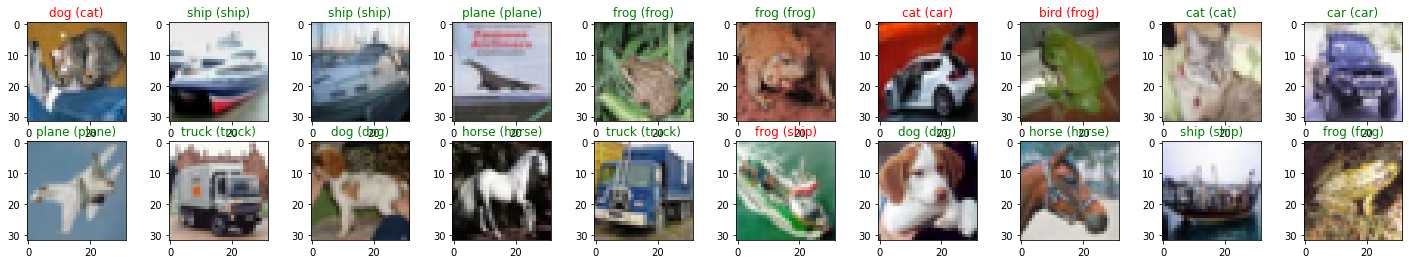

In [21]:
dataiter = iter(validation_loader)
images,labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
outputs = model.forward(images)
_,pred = torch.max(outputs,1)

fig = plt.figure(figsize=(25,4))

for i in np.arange(20):
  ax = fig.add_subplot(2,10,i+1)
  plt.imshow(im_convert(images[i]))
  ax.set_title("{} ({})".format(str(classes[pred[i].item()]), str(classes[labels[i].item()])), color =('green' if pred[i]==labels[i] else 'red'))